In [2]:
import sys
import torch
sys.path.append('../')
import model.ECGEncoder as ECGEncoder

In [2]:
print('this is test')

this is test


In [12]:
import argparse
from typing import Tuple
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def get_args_parser():
    parser = argparse.ArgumentParser('MAE pre-training', add_help=False)
    # Basic parameters
    parser.add_argument('--batch_size', default=64, type=int,
                        help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--epochs', default=400, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory '
                             'constraints)')
    
    # Model parameters
    parser.add_argument('--latent_dim', default=2048, type=int, metavar='N',
                        help='latent_dim')
    # SNP parameters
    parser.add_argument('--snp_size', default=(49, 120), type=Tuple, help='ecg input size')
    parser.add_argument('--use_snp', default=True, type=str2bool, help='use_snp')
    parser.add_argument('--snp_drop_out', default=0.0, type=float)
    parser.add_argument('--snp_att_depth', default=12, type=int)
    parser.add_argument('--snp_global_pool', default=False, type=str2bool, help='snp_global_pool')
    # ECG Model parameters
    parser.add_argument('--ecg_pretrained', default=True, type=str2bool,help='ecg_pretrained or not')
    parser.add_argument('--ecg_model', default='vit_base_patchX', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--ecg_pretrained_model',
                        default='/mnt/data/dingzhengyao/work/checkpoint/ECG_CMR/outputdir/1009/checkpoint-377-ncc-0.96.pth',
                        type=str, metavar='MODEL', help='path of pretaained model')
    parser.add_argument('--ecg_input_channels', type=int, default=1, metavar='N',
                        help='ecginput_channels')
    parser.add_argument('--ecg_input_electrodes', type=int, default=12, metavar='N',
                        help='ecg input electrodes')
    parser.add_argument('--ecg_time_steps', type=int, default=5000, metavar='N',
                        help='ecg input length')
    parser.add_argument('--ecg_input_size', default=(12, 5000), type=Tuple,
                        help='ecg input size')
    parser.add_argument('--ecg_patch_height', type=int, default=1, metavar='N',
                        help='ecg patch height')
    parser.add_argument('--ecg_patch_width', type=int, default=500, metavar='N',
                        help='ecg patch width')
    parser.add_argument('--ecg_patch_size', default=(1, 500), type=Tuple,
                        help='ecg patch size')
    parser.add_argument('--ecg_globle_pool', default=False,type=str2bool, help='ecg_globle_pool')
    parser.add_argument('--ecg_drop_out', default=0.0, type=float)
    parser.add_argument('--norm_pix_loss', action='store_true', default=False,
                        help='Use (per-patch) normalized pixels as targets for computing loss')
    

    # CMR Model parameters
    parser.add_argument('--cmr_model', default='vit_base_patch8', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--cmr_inchannels', default=10, type=int, metavar='N',
                        help='cmr_inchannels')
    parser.add_argument('--cmr_pretrained', default=False, type=str2bool,
                        help='cmr_pretrained or not')
    parser.add_argument('--img_size', default=80, type=int, metavar='N', help='img_size of cmr')
    parser.add_argument('--cmr_patch_height', type=int, default=8, metavar='N',
                        help='cmr patch height')
    parser.add_argument('--cmr_patch_width', type=int, default=8, metavar='N',
                        help='cmr patch width')
    parser.add_argument('--cmr_drop_out', default=0.0, type=float)
    
    # TAR Model parameters
    parser.add_argument('--tar_pretrained', default=True, type=str2bool,help='tar_pretrained or not')
    parser.add_argument('--tar_number', default=195, type=int, metavar='N',
                        help='Name of model to train')
    parser.add_argument('--tar_pretrained_path',
                        default='/home/dingzhengyao/Work/ECG_CMR/tabnet/pretrain_tabnet_model_by_train_data_1.zip',
                        type=str, metavar='MODEL', help='path of pretaained model')
    

    # LOSS parameters
    parser.add_argument('--loss', default='clip_loss', type=str, metavar='LOSS', help='loss function')
    parser.add_argument('--margin', default=0.025, type=float, metavar='MARGIN', help='margin for triplet loss')
    parser.add_argument('--temperature', default=0.1, type=float, metavar='TEMPERATURE',
                        help='temperature for nt_xent loss')
    parser.add_argument('--alpha_weight', default=0.25, type=float, metavar='ALPHA_WEIGHT',
                        help='alpha_weight for nt_xent loss')
    parser.add_argument('--loss_type', default='ecg_cmr', type=str, help='loss_type')

    # Augmentation parameters
    parser.add_argument('--input_size', type=tuple, default=(12, 5000))

    parser.add_argument('--timeFlip', type=float, default=0.33)

    parser.add_argument('--signFlip', type=float, default=0.33)

    # Optimizer parameters
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')

    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (absolute lr)')
    parser.add_argument('--blr', type=float, default=1e-4, metavar='LR',
                        help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
    parser.add_argument('--min_lr', type=float, default=0., metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')

    parser.add_argument('--warmup_epochs', type=int, default=40, metavar='N',
                        help='epochs to warmup LR')

    # Callback parameters
    parser.add_argument('--patience', default=-1, type=float,
                        help='Early stopping whether val is worse than train for specified nb of epochs (default: -1, i.e. no early stopping)')
    parser.add_argument('--max_delta', default=0, type=float,
                        help='Early stopping threshold (val has to be worse than (train+delta)) (default: 0)')

    # Dataset parameters

    parser.add_argument('--data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/train_data_dict_v5.pt',
                        type=str,
                        help='dataset path')
    parser.add_argument('--val_data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/val_data_dict_v5.pt',
                        type=str,
                        help='validation dataset path')
    parser.add_argument('--test_data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/test_data_dict_v5.pt',
                        type=str,
                        help='test dataset path')

    parser.add_argument('--output_dir', default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/output_dir',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/log_dir',
                        help='path where to tensorboard log')
    parser.add_argument('--wandb', type=str2bool,  default=True)
    parser.add_argument('--wandb_project', default='CMR_ECG_TAR',
                        help='project where to wandb log')
    # parser.add_argument('--wandb_dir', default='/mnt/data/dingzhengyao/work/checkpoint/ECG_CMR/wandb/1002',
    #                     help='project where to wandb save')
    parser.add_argument('--wandb_id', default='1001', type=str,
                        help='id of the current run')
    parser.add_argument('--device', default='cuda:3',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--pin_mem', action='store_true', default=True, 
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')

    # Distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    return parser

args = get_args_parser().parse_args(args=[])
print(args)

Namespace(batch_size=64, epochs=400, accum_iter=1, latent_dim=2048, snp_size=(49, 120), use_snp=True, snp_drop_out=0.0, snp_att_depth=12, snp_global_pool=False, ecg_pretrained=True, ecg_model='vit_base_patchX', ecg_pretrained_model='/mnt/data/dingzhengyao/work/checkpoint/ECG_CMR/outputdir/1009/checkpoint-377-ncc-0.96.pth', ecg_input_channels=1, ecg_input_electrodes=12, ecg_time_steps=5000, ecg_input_size=(12, 5000), ecg_patch_height=1, ecg_patch_width=500, ecg_patch_size=(1, 500), ecg_globle_pool=False, ecg_drop_out=0.0, norm_pix_loss=False, cmr_model='vit_base_patch8', cmr_inchannels=10, cmr_pretrained=False, img_size=80, cmr_patch_height=8, cmr_patch_width=8, cmr_drop_out=0.0, tar_pretrained=True, tar_number=195, tar_pretrained_path='/home/dingzhengyao/Work/ECG_CMR/tabnet/pretrain_tabnet_model_by_train_data_1.zip', loss='clip_loss', margin=0.025, temperature=0.1, alpha_weight=0.25, loss_type='ecg_cmr', input_size=(12, 5000), timeFlip=0.33, signFlip=0.33, weight_decay=0.05, lr=None, b

In [3]:
from model.SNPEncoder import SNPEncoder
from torchsummary import summary
model = SNPEncoder(args)
summary(model, input_size=( 49, 120),device='cpu')

cls_tokens.shape: torch.Size([2, 1, 120])
x.shape: torch.Size([2, 49, 120])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1              [-1, 50, 120]               0
MultiheadAttention-2  [[-1, 50, 120], [-1, 50, 50]]               0
         LayerNorm-3              [-1, 50, 120]             240
           Dropout-4              [-1, 50, 120]               0
            Linear-5              [-1, 50, 480]          58,080
              ReLU-6              [-1, 50, 480]               0
            Linear-7              [-1, 50, 120]          57,720
         LayerNorm-8              [-1, 50, 120]             240
           Dropout-9              [-1, 50, 120]               0
 TransformerBlock-10              [-1, 50, 120]               0
MultiheadAttention-11  [[-1, 50, 120], [-1, 50, 50]]               0
        LayerNorm-12              [-1, 50, 120]             240
          Dropout-

In [4]:


model_new = ECGEncoder.__dict__[args.ecg_new_model](
        img_size=args.ecg_input_size,
        patch_size=args.ecg_patch_size,
        in_chans=args.ecg_input_channels,
        num_classes=args.latent_dim,
    )
# model_new = vit_base_patch200(patch_size=(1,500))

AttributeError: 'NoneType' object has no attribute 'snp_size'

In [7]:
print(model_old)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(1, 500), stride=(1, 500))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=T

In [11]:
print(model_new)

ECGEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(1, 500), stride=(1, 500))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerN

In [18]:
state_dict = model_new.state_dict()
for name, param in state_dict.items():
    print(f'Parameter name: {name}')
    

Parameter name: cls_token
Parameter name: pos_embed
Parameter name: patch_embed.proj.weight
Parameter name: patch_embed.proj.bias
Parameter name: blocks.0.norm1.weight
Parameter name: blocks.0.norm1.bias
Parameter name: blocks.0.attn.qkv.weight
Parameter name: blocks.0.attn.qkv.bias
Parameter name: blocks.0.attn.proj.weight
Parameter name: blocks.0.attn.proj.bias
Parameter name: blocks.0.norm2.weight
Parameter name: blocks.0.norm2.bias
Parameter name: blocks.0.mlp.fc1.weight
Parameter name: blocks.0.mlp.fc1.bias
Parameter name: blocks.0.mlp.fc2.weight
Parameter name: blocks.0.mlp.fc2.bias
Parameter name: blocks.1.norm1.weight
Parameter name: blocks.1.norm1.bias
Parameter name: blocks.1.attn.qkv.weight
Parameter name: blocks.1.attn.qkv.bias
Parameter name: blocks.1.attn.proj.weight
Parameter name: blocks.1.attn.proj.bias
Parameter name: blocks.1.norm2.weight
Parameter name: blocks.1.norm2.bias
Parameter name: blocks.1.mlp.fc1.weight
Parameter name: blocks.1.mlp.fc1.bias
Parameter name: 

In [13]:
checkpoint = torch.load('/mnt/data/dingzhengyao/work/checkpoint/ECG_CMR/outputdir/1009/checkpoint-377-ncc-0.96.pth', map_location='cpu')
checkpoint_model = checkpoint['model']

In [19]:
msg = model_new.load_state_dict(checkpoint_model, strict=False)
print(msg)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weigh

In [16]:
print(checkpoint_model.keys())

odict_keys(['cls_token', 'pos_embed', 'mask_token', 'decoder_pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias

In [5]:
loss, imgs_hat, imgs_hat_masked = model_old(torch.randn(2,1, 12, 5000))
print(imgs_hat.shape)

torch.Size([2, 1, 12, 5000])


In [20]:
res = model_new(torch.randn(2,1, 12, 5000))
print(res.shape)

torch.Size([2, 2048])


In [29]:
# import model.resnet as resnet
# CMR_encoder = resnet.__dict__[args.cmr_model](
#             in_channels = args.cmr_inchannels,
#             latent_dim = args.latent_dim,
#             pretrained = args.cmr_pretrained,
#         )
from model.resnet  import resnet18
CMR_encoder=resnet18(in_channels = args.cmr_inchannels,latent_dim=args.latent_dim,pretrained=args.cmr_pretrained)

In [30]:
res = CMR_encoder(torch.randn(2,10, 224, 224))

In [10]:
from loss.nt_xent import NTXentLoss
from loss.triplet import TripletLoss
ecg = torch.randn(2,2048).to(args.device)
cmr = torch.randn(2,2048).to(args.device)
tar = torch.randn(2,2048).to(args.device)
loss_func_ntx = NTXentLoss(temperature=0.1,alpha_weight=0.25,args=args ).to(args.device)
loss_func_triplet = TripletLoss(margin=0.025).to(args.device)

In [13]:
from itertools import combinations
output_dict = {'ecg_feature':ecg,'cmr_feature':cmr,'tar_feature':tar}
all_combinations = combinations(output_dict.keys(), 2)

loss_dict = {}
loss_prefix = 'train_loss'
for key_combination in all_combinations:
    print(key_combination)
    loss_name = f"{loss_prefix}/{key_combination[0][:-8]}_{key_combination[1][:-8]}_loss"
    loss_dict[loss_name] = loss_func_ntx(output_dict[key_combination[0]], output_dict[key_combination[1]])
loss_dict[f"{loss_prefix}/total_loss"] = sum(loss_dict.values())
print(loss_dict)

('ecg_feature', 'cmr_feature')
('ecg_feature', 'tar_feature')
('cmr_feature', 'tar_feature')
{'train_loss/ecg_cmr_loss': tensor(0.5041, device='cuda:3'), 'train_loss/ecg_tar_loss': tensor(0.6826, device='cuda:3'), 'train_loss/cmr_tar_loss': tensor(0.8210, device='cuda:3'), 'train_loss/total_loss': tensor(2.0077, device='cuda:3')}


In [2]:
from bs4 import BeautifulSoup
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

def get_ecg(ecg_path):
    ecg_file = open(ecg_path).read()
    bs = None
    try:
        bs = BeautifulSoup(ecg_file, features="lxml")
    except:
        pass
    ecg_waveform_length = 5000
    if ecg_waveform_length == 600:
        waveform = bs.body.cardiologyxml.mediansamples
    else:
        waveform = bs.body.cardiologyxml.stripdata
    # print(waveform)
    # print(type(waveform))
    data_numpy = None
    bs_measurement = bs.body.cardiologyxml.restingecgmeasurements
    heartbeat = int(bs_measurement.find_all("VentricularRate".lower())[0].string)

    for each_wave in waveform.find_all("waveformdata"):
        each_data = each_wave.string.strip().split(",")
        each_data = [s.replace('\n\t\t', '') for s in each_data]
        each_data = np.array(each_data, dtype=np.float32)
        # plt.plot(each_data)
        try:
            seasonal_decompose_result = seasonal_decompose(each_data, model="additive",
                                                        period=int(ecg_waveform_length*6/heartbeat))
        except:
            return None
        trend = seasonal_decompose_result.trend
        start, end = 0, ecg_waveform_length - 1
        sflag, eflag = False, False
        for i in range(ecg_waveform_length):
            if np.isnan(trend[i]):
                start += 1
            else:
                sflag = True
            if np.isnan(trend[ecg_waveform_length-1-i]):
                end -= 1
            else:
                eflag = True
            if sflag and eflag:
                break
        trend[:start] = trend[start]
        trend[end:] = trend[end]
        # trend[np.isnan(trend)] = 0.0
        result = np.array(seasonal_decompose_result.observed - trend)
        # plt.plot(result)
        # plt.show()
        # exit()
        if data_numpy is None:
            data_numpy = result
        else:
            data_numpy = np.vstack((data_numpy, result))


    for channel in data_numpy:
        # print(channel.shape)
        unique_values = np.unique(channel)
        if len(unique_values) == 1: 
            return None
    
    return data_numpy

In [7]:
import pandas as pd
import numpy as np
import os
from multiprocessing import Pool

def process_ecg(i):
    res = get_ecg(os.path.join('/mnt/data/ukb_heartmri/ukb_20205',ecg[i]))
    if res is None:
        print(f'ecg {ecg[i]} is None')
        return ecg[i]
    # print(f'Finish processing ecg {ecg[i]}')
    return None

csv = pd.read_csv('/mnt/data/ukb_collation/ukb_ecg_cmr/data/test_v3.csv')
ecg = csv['20205_2_0'].values
print(ecg.shape)

# 创建一个进程池，进程数等于你的 CPU 核心数
with Pool(os.cpu_count()) as p:
    non = p.map(process_ecg, range(ecg.shape[0]))

# 过滤掉 None 值
non = [i for i in non if i is not None]

print(non)

(8309,)


/tmp/ipykernel_26588/741601615.py:14: DtypeWarning: Columns (176) have mixed types. Specify dtype option on import or set low_memory=False.
  csv = pd.read_csv('/mnt/data/ukb_collation/ukb_ecg_cmr/data/test_v3.csv')
/data/Anaconda3/envs/pl/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
/data/Anaconda3/envs/pl/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warn

ecg 1109736_20205_2_0.xml is None
['1109736_20205_2_0.xml']


In [12]:
# /mnt/data/ukb_heartmri/ukb_20205/2652758_20205_2_0.xml
import pandas as pd
import numpy as np
import os
csv = pd.read_csv('/mnt/data/ukb_collation/ukb_ecg_cmr/data/train_v3.csv')
ecg = csv['20205_2_0'].values
print(ecg.shape)
non=[]
for i in range(ecg.shape[0]):
    res = get_ecg(os.path.join('/mnt/data/ukb_heartmri/ukb_20205',ecg[i]))
    # print(res.shape)
    if i % 100 ==0:
        print(i)
    if res is None:
        non.append(ecg[i])
        print(ecg[i])
        
print(non)

(24918,)
0


/data/Anaconda3/envs/pl/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


100
175
200
300
318


In [12]:
# 重写和运行上述代码
import torch

def softXEnt(target, logits):
    logprobs = torch.nn.functional.log_softmax(logits, dim=1)
    loss = -(target * logprobs).sum() / logits.shape[0]
    return loss

# 创建一个 4x4 的 target 矩阵和 4x4 的单位矩阵作为 logits
target = torch.randn(4, 4)
logits = torch.eye(4)

# 计算使用原始 target 和 logits 的 softXEnt
loss_original = softXEnt(target, logits)

# 计算使用 target 的转置和 logits 的 softXEnt
loss_transposed = softXEnt(target.t(), logits)

loss_original, loss_transposed, torch.equal(loss_original, loss_transposed)



(tensor(-2.3446), tensor(-2.3446), True)

In [16]:
import torch

# 假设我们有两组一维向量
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = torch.tensor([[7.0, 8.0, 9.0], [10.0, 11.0, 12.0]])

# 计算每组向量的平方范数
a_square_norm = (a ** 2).sum(dim=1)
b_square_norm = (b ** 2).sum(dim=1)
print(a_square_norm)
print(b_square_norm)
print(a_square_norm.unsqueeze(0))
print(b_square_norm.unsqueeze(1))
# 计算两组向量的点积
dot_product = torch.matmul(a, b.t())
print(dot_product)

# 计算欧氏距离的平方
distances = a_square_norm.unsqueeze(0) - 2.0 * dot_product + b_square_norm.unsqueeze(1)

print(distances)

tensor([14., 77.])
tensor([194., 365.])
tensor([[14., 77.]])
tensor([[194.],
        [365.]])
tensor([[ 50.,  68.],
        [122., 167.]])
tensor([[108., 135.],
        [135., 108.]])


In [22]:
# 导入torch库
import torch

# 定义两个张量a和b
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0],[7.0, 8.0, 9.0]])
b = torch.tensor([[10.0, 11.0, 12.0], [13.0, 14.0, 15.0],[16.0, 17.0, 18.0]])

# 计算欧氏距离
# 方法一：使用torch中的函数
distances = torch.cdist(b.unsqueeze(0), a.unsqueeze(0), p=2)

# 方法二：手动计算
# 扩展a和b以便于广播，然后计算差值
diff = a.unsqueeze(1) - b.unsqueeze(0)
# 计算差值的平方和，然后取平方根得到欧氏距离
euclidean_distances = torch.sum(diff ** 2, dim=2)

distances, euclidean_distances



(tensor([[[15.5885, 10.3923,  5.1962],
          [20.7846, 15.5885, 10.3923],
          [25.9808, 20.7846, 15.5885]]]),
 tensor([[243., 432., 675.],
         [108., 243., 432.],
         [ 27., 108., 243.]]))

In [1]:
col = [
    "rs79534072_A", "rs643420_T", "rs12404144_C", "rs2009594_A", "rs7354918_G", "rs650720_T", "rs3738685_T", "rs12724121_A", "rs934012_A", "rs7255_T", "rs3813243_T", "rs12988307_C", "rs2562845_C", "rs2042995_C", "rs17076_G", "rs142556838_T", "rs1873164_G", "rs55844607_G", "rs10497529_A", "rs55834511_C", "rs9856926_A", "rs744892_A", "rs6809328_C", "rs2686630_C", "rs57078287_G", "rs6549251_T", "rs62253179_A", "rs62253185_A", "rs55914222_C", "rs9850919_C", "rs698099_G", "rs67846163_G", "rs2968210_C", "rs154455_T", "rs10043782_T", "rs55745974_T", "rs10065122_C", "rs2438150_C", "rs72787559_T", "rs335196_A", "rs7702622_T", "rs434775_T", "rs72801474_A", "rs11745702_C", "rs13165478_A", "rs1630736_T", "rs7744333_C", "rs730506_C", "rs4151702_C", "rs4707174_C", "rs7752142_A", "rs9401921_G", "rs2328474_T", "rs13203975_A", "rs58127685_T", "rs2107595_A", "rs336284_A", "rs741408_T", "rs150260620_A", "rs13234515_T", "rs4078435_C", "rs6974735_G", "rs11768878_G", "rs11761337_A", "rs1583081_T", "rs7786419_A", "rs2307036_A", "rs1915986_A", "rs3789849_C", "rs907183_C", "rs4840467_A", "rs7832708_T", "rs6601450_T", "rs12541800_G", "rs11250162_T", "rs7823808_C", "rs7009229_C", "rs34557926_T", "rs13252512_G", "rs34866937_A", "rs11786896_T", "rs10740811_G", "rs10763764_A", "rs2893923_T", "rs1896995_T", "rs11593126_G", "rs2797983_G", "rs1343094_T", "rs12217597_C", "rs7904979_G", "rs10885378_C", "rs12241957_C", "rs7921223_C", "rs117550412_T", "rs17617337_T", "rs72842211_T", "rs621679_A", "rs78777726_C", "rs12285933_T", "rs11604825_T", "rs11039348_A", "rs72931764_A", "rs875107_C", "rs747249_A", "rs861202_G", "rs4148674_C", "rs73139037_T", "rs73145172_T", "rs7299436_G", "rs597808_A", "rs653178_C", "rs3914956_T", "rs7994761_G", "rs376439_G", "rs2284651_C", "rs61991200_G", "rs4905134_A", "rs11844114_T", "rs17352842_T", "rs1561207_T", "rs627634_T", "rs1441358_G", "rs1048661_T", "rs12905223_C", "rs11638445_A", "rs11633377_G", "rs11073716_T", "rs12595786_C", "rs35630683_C", "rs72630465_T", "rs56864281_A", "rs8039472_A", "rs35808647_A", "rs3803405_A", "rs7166287_C", "rs77870048_T", "rs62053262_G", "rs7500448_G", "rs488327_C", "rs511893_G", "rs2126202_C", "rs4791494_G", "rs12453217_T", "rs61572747_G", "rs55938136_G", "rs242562_A", "rs2696532_G", "rs199470_C", "rs1563304_T", "rs17608766_C", "rs617759_T", "rs59945167_T", "rs2070458_A", "rs2267038_G", "rs133885_A", "rs4820654_G", "rs57774511_C"
    ]
print(len(col))

157


In [3]:
import model.ECGEncoder as ECGEncoder
model = ECGEncoder.__dict__[args.ecg_new_model](
        img_size=args.ecg_input_size,
        patch_size=args.ecg_patch_size,
        in_chans=args.ecg_input_channels,
        num_classes=args.latent_dim,
    )


In [4]:
res = model(torch.randn(2,1, 12, 5000))
print(res.shape)

x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
x.shape:torch.Size([2, 121, 768])
torch.Size([2, 2048])


In [1]:
snp_dict = {'AAo_aortic_distensibility': [36], 
                        'AAo_max_area': [84, 89, 101, 102, 103, 105, 112, 116, 120, 121, 136, 137, 139, 141, 140, 156, 8, 23, 22, 28, 31, 33, 35, 37, 39, 40, 45, 52, 53, 56, 57, 58, 61, 63, 64, 69, 71, 74, 76, 77], 
                        'AAo_min_area': [83, 88, 101, 102, 103, 104, 106, 112, 116, 119, 121, 136, 138, 141, 140, 156, 8, 23, 22, 21, 28, 31, 33, 34, 35, 37, 38, 41, 45, 46, 52, 53, 56, 60, 62, 63, 64, 70, 73, 77],
                        'DAo_aortic_distensibility': [87, 78], 
                        'DAo_max_area': [82, 86, 113, 117, 118, 122, 151, 5, 9, 30, 49, 55],
                        'DAo_min_area': [81, 85, 86, 117, 118, 122, 135, 151, 5, 9, 30, 49, 54, 55],
                        'Ecc_AHA_1': [11], 
                        'Ecc_AHA_10': [14], 
                        'Ecc_AHA_13': [75], 
                        'Ecc_AHA_15': [65], 
                        'Ecc_AHA_2': [68, 72], 
                        'Ecc_AHA_5': [95, 12], 
                        'Ecc_AHA_8': [32], 
                        'Ecc_global': [94, 1, 11], 
                        'Ell_3': [149], 
                        'Ell_5': [7], 
                        'Ell_6': [0], 
                        'Err_AHA_1': [111, 44], 
                        'Err_AHA_10': [15], 
                        'Err_AHA_11': [17], 
                        'Err_AHA_5': [107], 
                        'Err_AHA_6': [59], 
                        'Err_global': [90], 
                        'LAEF': [154], 
                        'LVEDV': [92, 93, 110, 11, 16, 18, 50], 
                        'LVEF': [94, 2, 12, 79], 
                        'LVESV': [91, 94, 3, 153, 11, 16, 18, 66, 79], 
                        'LVM': [96, 124, 11, 18], 
                        'LVSV': [50], 
                        'RVEDV': [109, 149, 13], 
                        'RVEF': [94, 6, 20, 67, 80], 
                        'RVESV': [91, 94, 110, 149, 6, 10, 13, 19], 
                        'RVSV': [109, 114], 
                        'WT_AHA_1': [123, 48], 
                        'WT_AHA_10': [133, 51], 
                        'WT_AHA_11': [133, 142, 144, 145, 152, 24, 47], 
                        'WT_AHA_12': [129, 133, 134, 144, 147, 26, 47], 
                        'WT_AHA_13': [115, 125, 146], 
                        'WT_AHA_14': [128, 147], 
                        'WT_AHA_15': [133, 4], 
                        'WT_AHA_16': [132, 144, 147, 4], 
                        'WT_AHA_2': [48], 
                        'WT_AHA_3': [127], 
                        'WT_AHA_5': [97, 126, 155, 25], 
                        'WT_AHA_6': [131, 25], 
                        'WT_AHA_7': [99, 129, 130], 
                        'WT_AHA_8': [100, 131, 150, 29, 42], 
                        'WT_AHA_9': [143, 43], 
                        'WT_global': [98, 99, 108, 128, 143, 144, 148, 27, 48]}

In [2]:
import torch
tensor = torch.randn(8000, 471)
selected_data = []
for key in snp_dict.keys():
    while len(snp_dict[key]) < 40:
        snp_dict[key] = snp_dict[key] + snp_dict[key]
    snp_dict[key] = snp_dict[key][:40]
    snp_dict[key] = [i*3+j for i in snp_dict[key] for j in range(3)]
    index_tensor = torch.tensor(snp_dict[key])
    selected_data.append(tensor[:, index_tensor]) 
selected_data = torch.stack(selected_data, dim=1)
print(selected_data.shape)

torch.Size([8000, 49, 120])


In [12]:
for key in snp_dict.keys():
    print(len(snp_dict[key]))

120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120


In [6]:
la = []
print(len(snp_dict.keys()))
for key in snp_dict.keys():
    la.append(snp_dict[key])
flat_list = sum(la, [])
print(flat_list)
flat_list.sort()
my_set = set(flat_list)
my_list = list(my_set)
print(my_list)
print(len(my_list))

49
[36, 84, 89, 101, 102, 103, 105, 112, 116, 120, 121, 136, 137, 139, 141, 140, 156, 8, 23, 22, 28, 31, 33, 35, 37, 39, 40, 45, 52, 53, 56, 57, 58, 61, 63, 64, 69, 71, 74, 76, 77, 83, 88, 101, 102, 103, 104, 106, 112, 116, 119, 121, 136, 138, 141, 140, 156, 8, 23, 22, 21, 28, 31, 33, 34, 35, 37, 38, 41, 45, 46, 52, 53, 56, 60, 62, 63, 64, 70, 73, 77, 87, 78, 82, 86, 113, 117, 118, 122, 151, 5, 9, 30, 49, 55, 81, 85, 86, 117, 118, 122, 135, 151, 5, 9, 30, 49, 54, 55, 11, 14, 75, 65, 68, 72, 95, 12, 32, 94, 1, 11, 149, 7, 0, 111, 44, 15, 17, 107, 59, 90, 154, 92, 93, 110, 11, 16, 18, 50, 94, 2, 12, 79, 91, 94, 3, 153, 11, 16, 18, 66, 79, 96, 124, 11, 18, 50, 109, 149, 13, 94, 6, 20, 67, 80, 91, 94, 110, 149, 6, 10, 13, 19, 109, 114, 123, 48, 133, 51, 133, 142, 144, 145, 152, 24, 47, 129, 133, 134, 144, 147, 26, 47, 115, 125, 146, 128, 147, 133, 4, 132, 144, 147, 4, 48, 127, 97, 126, 155, 25, 131, 25, 99, 129, 130, 100, 131, 150, 29, 42, 143, 43, 98, 99, 108, 128, 143, 144, 148, 27, 48]


In [7]:
print(len([84, 89, 101, 102, 103, 105, 112, 116, 120, 121, 136, 137, 139, 141, 140, 156, 8, 23, 22, 28, 31, 33, 35, 37, 39, 40, 45, 52, 53, 56, 57, 58, 61, 63, 64, 69, 71, 74, 76, 77]))

40


In [2]:
import model.CMREncoder as CMREncoder
model = CMREncoder.__dict__['vit_base_patch8'](
            in_chans = 10,
            img_size = 80,
            num_classes = 2048,
            drop_rate = 0.0,
            use_snp = True
        )

kwargs: {'patch_size': 8, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4, 'qkv_bias': True, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'in_chans': 10, 'img_size': 80, 'num_classes': 2048, 'drop_rate': 0.0}


In [3]:
x= torch.randn(2,10, 80, 80)
snp = torch.randn(2,49,120)
res = model(x,snp)
print(res.shape)

x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
x.shape: torch.Size([2, 101, 768])
torch.Size([2, 2048])


In [13]:
model = torch.nn.MultiheadAttention(768, 8,batch_first=True)
query = torch.randn(2, 49, 120)
fc = torch.nn.Linear(120, 768)
query = fc(query)
print(query.shape)
cnn1d = torch.nn.Conv1d(in_channels=49, out_channels=121, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=True)
query = cnn1d(query)
print(query.shape)
key = torch.randn(2, 121, 768)
value = torch.randn(2, 121, 768)
attn_output, attn_output_weights = model(query, key, value)
print(f'attn_output.shape: {attn_output.shape}, attn_output_weights.shape: {attn_output_weights.shape}')

torch.Size([2, 49, 768])
torch.Size([2, 121, 768])
attn_output.shape: torch.Size([2, 121, 768]), attn_output_weights.shape: torch.Size([2, 121, 121])


In [19]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout,batch_first=True)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        attention = self.attention(query, key, value, attn_mask=mask)[0]
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Example parameters
embed_size = 256
heads = 8
dropout = 0.1
forward_expansion = 4

# Example input
x = torch.rand(32, 10, embed_size)  # (batch size,sequence length , embedding size)


# Model
model = TransformerBlock(embed_size, heads, dropout, forward_expansion)
output = model(x, x, x)

print(output.shape)  # The output shape will be the same as the input shape
blocks=[1,2,3,4,5,6,7,8]
snp_attention = nn.Sequential(*[
            TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(len(blocks))
        ])
for block in snp_attention:
    print(block)
    output = block(x, x, x)
    print(output.shape)
print(snp_attention)
# output = snp_attention(x, x, x)


torch.Size([32, 10, 256])
TransformerBlock(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
torch.Size([32, 10, 256])
TransformerBlock(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias

In [ ]:
snp_attention = [TransformerBlock(
            embed_size=kwargs['embed_dim'],
            heads=kwargs['num_heads'],
            dropout=kwargs['drop_rate'],
            forward_expansion=kwargs['mlp_ratio']) for _ in range(len(self.blocks))]

In [5]:
import torch
print(torch.randn(1,1,10,10))

tensor([[[[ 5.1139e-01,  6.9811e-01, -8.8071e-01,  5.0014e-01,  1.6331e+00,
            7.4109e-01, -5.9044e-01, -1.3570e+00,  1.5240e+00, -8.8955e-01],
          [ 7.0715e-01, -1.9170e+00, -1.3139e+00, -7.1571e-01, -2.1882e+00,
           -1.6789e-01, -9.3906e-01,  1.6039e-01,  1.4526e+00,  1.9749e+00],
          [ 2.1625e+00, -3.5487e-01,  8.0556e-01,  8.9195e-01,  1.9967e-01,
            3.6870e-03, -7.1267e-01, -7.0969e-01,  2.7000e-01, -9.1817e-01],
          [-2.0320e+00, -1.0410e+00,  9.6955e-01,  9.2114e-01,  9.0249e-01,
           -1.1899e-01, -5.0441e-04,  1.0383e+00, -2.2779e-01,  2.0136e+00],
          [ 7.5779e-01, -1.8868e+00,  5.1095e-01, -5.1010e-01, -9.0492e-01,
           -1.7090e+00, -1.3796e+00, -8.3750e-01,  8.1200e-01,  4.5537e-01],
          [ 8.5657e-01,  2.6001e-01, -1.1027e+00,  6.9889e-01,  9.1474e-01,
           -1.8014e+00, -9.9651e-01, -4.6599e-01, -9.4611e-01,  1.0747e+00],
          [ 8.2688e-02, -2.1657e-01, -8.7305e-01, -3.1508e-01,  2.0100e+00,
      

In [6]:
from model.tabnet_model import TabNetPretraining, create_group_matrix
TAR_encoder = TabNetPretraining(input_dim=195,
                                             group_attention_matrix=create_group_matrix([], 195).to('cuda:3'),
                                             device='cuda:3', latent_dim=1024)
from torchinfo import summary
summary(TAR_encoder,input_size=(64,195),device='cuda:3')

Layer (type:depth-idx)                                       Output Shape              Param #
TabNetPretraining                                            [64, 1024]                --
├─EmbeddingGenerator: 1-1                                    [64, 195]                 --
├─TabNetEncoder: 1-2                                         [64, 8]                   --
│    └─BatchNorm1d: 2-1                                      [64, 195]                 390
│    └─FeatTransformer: 2-2                                  [64, 16]                  1,152
│    │    └─GLU_Block: 3-1                                   [64, 16]                  6,880
│    └─ModuleList: 2-12                                      --                        (recursive)
│    │    └─FeatTransformer: 3-17                            --                        (recursive)
│    └─FeatTransformer: 2-6                                  --                        (recursive)
│    │    └─GLU_Block: 3-5                                   

In [11]:
import torch
import torch.nn.functional as F

# 生成一个10*10的随机tensor
tensor1 = torch.randn(10, 10)

# 生成一个10*10的单位矩阵
tensor2 = torch.eye(10)
print(torch.arange(len(tensor1)))
print(tensor1)
# 使用torch的cross_entropy计算tensor1和tensor2
cross_entropy_1 = F.cross_entropy(tensor1, torch.arange(len(tensor1)))

# 将tensor1转置后与tensor2做cross_entropy
cross_entropy_2 = F.cross_entropy(tensor1.t(), torch.arange(len(tensor1)))

cross_entropy_1, cross_entropy_2



tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([[ 1.0128,  0.1896, -2.4758, -0.7117,  0.5688,  0.9133,  0.3048,  0.0797,
          1.7065, -0.9938],
        [ 2.1443, -0.0980,  1.2087,  0.7434, -0.5715, -0.8871, -0.5186, -1.1466,
         -0.6590,  2.3179],
        [ 0.1459, -0.6751,  1.7570, -1.4916, -0.9797,  0.1173, -2.1208,  0.4785,
          0.0576, -0.6332],
        [-0.4425,  1.5815,  0.1291,  0.0684,  2.2791, -0.2099,  1.9327, -0.1907,
         -0.0598,  2.4359],
        [-1.0678,  0.8696,  0.6624,  0.5611, -2.5525, -2.4795,  1.2111,  1.8260,
          1.6325,  1.6999],
        [-0.2327,  0.1760,  0.1092, -0.1660, -0.7890, -1.1932,  0.0429, -1.4152,
         -0.6056,  0.2903],
        [-0.4656,  1.2410, -0.9214, -0.0034, -0.2849,  0.1114, -0.3553,  2.5984,
         -2.0553,  0.0451],
        [ 0.2965,  0.2165, -0.2589,  0.0033, -1.5173, -1.6980,  0.2787,  0.3593,
          1.2352,  0.5694],
        [-0.6082,  0.6363, -0.4313, -2.1708, -1.1455, -0.6580,  0.5761,  1.1367,
        

RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

In [10]:
lables = F.one_hot(torch.arange(start=0, end=64, dtype=torch.int64), num_classes=64).float()
print(lables)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [13]:
tensor1 = torch.randn(5, 5)
print(tensor1.t())
print(torch.transpose(tensor1, 0, 1))
print(torch.equal(tensor1.t(), torch.transpose(tensor1, 0, 1)))

tensor([[-0.7694, -2.4397,  0.8835,  0.3638, -0.3139],
        [-0.1560,  0.5092,  0.5933,  2.5126,  0.4168],
        [ 0.0857,  0.2075, -0.1624,  1.7552, -0.1749],
        [-1.5560, -0.9329,  2.4862, -0.3974, -1.3995],
        [ 1.4267, -0.3341, -0.8650,  0.1747,  0.9371]])
tensor([[-0.7694, -2.4397,  0.8835,  0.3638, -0.3139],
        [-0.1560,  0.5092,  0.5933,  2.5126,  0.4168],
        [ 0.0857,  0.2075, -0.1624,  1.7552, -0.1749],
        [-1.5560, -0.9329,  2.4862, -0.3974, -1.3995],
        [ 1.4267, -0.3341, -0.8650,  0.1747,  0.9371]])
True


In [14]:
print(torch.randn(64,2048).t().shape)

torch.Size([2048, 64])


In [16]:
from itertools import combinations
output_dict = {'ecg_feature': 1, 'cmr_feature': 2, 'tar_feature': 3}
all_combinations = combinations(output_dict.keys(), 2)
for key_combination in all_combinations:
    print(key_combination)


('ecg_feature', 'cmr_feature')
('ecg_feature', 'tar_feature')
('cmr_feature', 'tar_feature')


In [20]:
import torchvision.models as models
base_model = models.resnet18(pretrained=False)
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/data/Anaconda3/envs/pl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/Anaconda3/envs/pl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
x = torch.rand(2,2,2)
print(x[:,0,:])
print(x[:,0])

tensor([[0.3428, 0.3307],
        [0.1235, 0.9866]])
tensor([[0.3428, 0.3307],
        [0.1235, 0.9866]])


In [1]:
import torch
import numpy as np
import os
dict_data = torch.load('/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/val_data_dict_v6.pt')
print(dict_data.keys())

dict_keys(['val_ecg_data', 'val_tar_data', 'val_snp_data', 'val_cha_data', 'val_I21_data', 'val_I42_data', 'val_I48_data', 'val_I50_data', 'val_cmr_data', 'val_eid'])


tensor(5504371)
torch.Size([12, 5000])
torch.Size([50, 80, 80])


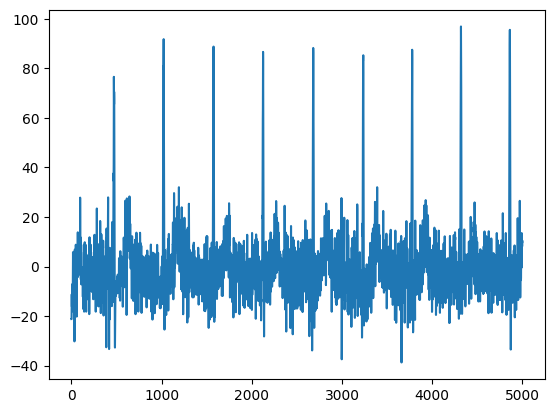

In [6]:
import matplotlib.pyplot as plt
import nibabel as nib
for i,eid in enumerate(dict_data['val_eid']):
    if i == 10:
        print(eid)
        ecg = dict_data['val_ecg_data'][i]
        cmr = dict_data['val_cmr_data'][i]
        print(ecg.shape)
        plt.plot(ecg[0])
        print(cmr.shape) 
        nib.save(nib.Nifti1Image(np.array(cmr), np.eye(4)), f'/home/dingzhengyao/Work/ECG_CMR/ECG_CMR_TAR/Project_version1/test_code/test_generate/val_cmr_{eid}.nii.gz')



In [17]:
from utils.preprocess import get_img
import nibabel
real_cmr = get_img('5504371_20209_2_0/sa.nii.gz')
print(real_cmr.shape)
nib.save(nib.Nifti1Image(np.array(real_cmr), np.eye(4)), f'/home/dingzhengyao/Work/ECG_CMR/ECG_CMR_TAR/Project_version1/test_code/test_generate/real_cmr.nii.gz')

(50, 80, 80)


In [10]:
import numpy as np
from bs4 import BeautifulSoup
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
def get_ecg( ecg_path):
    ecg_file = open(ecg_path).read()
    bs = None
    try:
        bs = BeautifulSoup(ecg_file, features="lxml")
    except:
        pass
    ecg_waveform_length = 5000
    if ecg_waveform_length == 600:
        waveform = bs.body.cardiologyxml.mediansamples
    else:
        waveform = bs.body.cardiologyxml.stripdata
    # print(waveform)
    # print(type(waveform))
    data_numpy = None
    bs_measurement = bs.body.cardiologyxml.restingecgmeasurements
    heartbeat = int(bs_measurement.find_all("VentricularRate".lower())[0].string)

    for each_wave in waveform.find_all("waveformdata"):
        each_data = each_wave.string.strip().split(",")
        each_data = [s.replace('\n\t\t', '') for s in each_data]
        each_data = np.array(each_data, dtype=np.float32)
        # plt.plot(each_data)
        seasonal_decompose_result = seasonal_decompose(each_data, model="additive",
                                                        period=int(ecg_waveform_length*6/heartbeat))
        trend = seasonal_decompose_result.trend
        start, end = 0, ecg_waveform_length - 1
        sflag, eflag = False, False
        for i in range(ecg_waveform_length):
            if np.isnan(trend[i]):
                start += 1
            else:
                sflag = True
            if np.isnan(trend[ecg_waveform_length-1-i]):
                end -= 1
            else:
                eflag = True
            if sflag and eflag:
                break
        trend[:start] = trend[start]
        trend[end:] = trend[end]
        # trend[np.isnan(trend)] = 0.0
        result = np.array(seasonal_decompose_result.observed - trend)
        # plt.plot(result)
        # plt.show()
        # exit()
        if data_numpy is None:
            data_numpy = result
        else:
            data_numpy = np.vstack((data_numpy, result))

    return data_numpy
real_data = get_ecg('/mnt/data/ukb_heartmri/ukb_20205/5504371_20205_2_0.xml')
real_data = torch.from_numpy(real_data).float()

/data/Anaconda3/envs/pl/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [11]:
print(real_data)
print(ecg)
print(torch.equal(real_data, ecg))

tensor([[-2.1202e+01, -2.1202e+01, -2.1202e+01,  ...,  9.5064e+00,
          1.0506e+01,  8.5064e+00],
        [-1.3829e+01, -1.3829e+01, -7.8294e+00,  ...,  4.2670e+01,
          4.1670e+01,  4.0670e+01],
        [ 7.3725e+00,  7.3725e+00,  1.3372e+01,  ...,  3.3163e+01,
          3.1163e+01,  3.2163e+01],
        ...,
        [-2.0330e+00, -3.3028e-02,  4.9670e+00,  ...,  8.0760e+01,
          7.7760e+01,  7.6760e+01],
        [-1.2178e+01, -1.2178e+01, -7.1780e+00,  ...,  4.8539e+01,
          4.5539e+01,  4.1539e+01],
        [-1.5310e+01, -1.5310e+01, -1.2310e+01,  ...,  3.0167e+01,
          2.7167e+01,  2.5167e+01]])
tensor([[-2.1202e+01, -2.1202e+01, -2.1202e+01,  ...,  9.5064e+00,
          1.0506e+01,  8.5064e+00],
        [-1.3829e+01, -1.3829e+01, -7.8294e+00,  ...,  4.2670e+01,
          4.1670e+01,  4.0670e+01],
        [ 7.3725e+00,  7.3725e+00,  1.3372e+01,  ...,  3.3163e+01,
          3.1163e+01,  3.2163e+01],
        ...,
        [-2.0330e+00, -3.3028e-02,  4.9670e+00

In [12]:
import torch
from torchvision.transforms import transforms
from torchvision.transforms import v2

data = torch.randn(50,80,80)
transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(80,80),scale=(0.8,1.0),ratio=(0.9,1.1)),
])
data = transforms(data)
print(data.shape)

torch.Size([50, 80, 80])


/data/Anaconda3/envs/pl/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [27]:
from sklearn.preprocessing import StandardScaler
y_train = [[1,2,3,4,5],[1,3,5,7,9],[1,4,9,20,100]]
# 假设 y_train 是一个包含70个变量的矩阵
scaler = StandardScaler()

# 对训练数据进行标准化
y_train_scaled = scaler.fit_transform(y_train)

print(y_train_scaled)
scaler = StandardScaler()
y_test = [[1,1],[2,3],[3,5],[4,7],[5,9]]
y_test_scaled = scaler.fit_transform(y_test)
print(y_test_scaled)
print(scaler.inverse_transform(y_test_scaled))
print(scaler.inverse_transform([[2,2],[3,3],[7,4]]))

[[ 0.         -1.22474487 -1.06904497 -0.91202919 -0.75220493]
 [ 0.          0.         -0.26726124 -0.48001536 -0.66102858]
 [ 0.          1.22474487  1.33630621  1.39204455  1.41323351]]
[[-1.41421356 -1.41421356]
 [-0.70710678 -0.70710678]
 [ 0.          0.        ]
 [ 0.70710678  0.70710678]
 [ 1.41421356  1.41421356]]
[[1. 1.]
 [2. 3.]
 [3. 5.]
 [4. 7.]
 [5. 9.]]
[[ 5.82842712 10.65685425]
 [ 7.24264069 13.48528137]
 [12.89949494 16.3137085 ]]


In [2]:
import torch
ecg_checkpoint = torch.load('/mnt/data/dingzhengyao/work/checkpoint/preject_version1/output_dir/7005/checkpoint-67-loss-2.76.pth', map_location='cpu')
ecg_checkpoint_model = ecg_checkpoint['model']
print(ecg_checkpoint_model.keys())

odict_keys(['ECG_encoder.cls_token', 'ECG_encoder.pos_embed', 'ECG_encoder.patch_embed.proj.weight', 'ECG_encoder.patch_embed.proj.bias', 'ECG_encoder.blocks.0.norm1.weight', 'ECG_encoder.blocks.0.norm1.bias', 'ECG_encoder.blocks.0.attn.qkv.weight', 'ECG_encoder.blocks.0.attn.qkv.bias', 'ECG_encoder.blocks.0.attn.proj.weight', 'ECG_encoder.blocks.0.attn.proj.bias', 'ECG_encoder.blocks.0.norm2.weight', 'ECG_encoder.blocks.0.norm2.bias', 'ECG_encoder.blocks.0.mlp.fc1.weight', 'ECG_encoder.blocks.0.mlp.fc1.bias', 'ECG_encoder.blocks.0.mlp.fc2.weight', 'ECG_encoder.blocks.0.mlp.fc2.bias', 'ECG_encoder.blocks.1.norm1.weight', 'ECG_encoder.blocks.1.norm1.bias', 'ECG_encoder.blocks.1.attn.qkv.weight', 'ECG_encoder.blocks.1.attn.qkv.bias', 'ECG_encoder.blocks.1.attn.proj.weight', 'ECG_encoder.blocks.1.attn.proj.bias', 'ECG_encoder.blocks.1.norm2.weight', 'ECG_encoder.blocks.1.norm2.bias', 'ECG_encoder.blocks.1.mlp.fc1.weight', 'ECG_encoder.blocks.1.mlp.fc1.bias', 'ECG_encoder.blocks.1.mlp.fc2.

In [4]:
ECG_encoder_keys = {k: v for k, v in ecg_checkpoint_model.items() if k.startswith('ECG_encoder')}

In [16]:
import model.ECGEncoder as ECGEncoder
model = ECGEncoder.__dict__[args.ecg_model](
                img_size=(12, 5000),
                patch_size=(1, 500),
                in_chans=1,
                num_classes=82,
                drop_rate=0.1,
                args=args,
            )

In [18]:
model.state_dict().keys()

odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

In [19]:
new_keys = {k.replace('ECG_encoder.', ''): v for k, v in ECG_encoder_keys.items()}
print(ECG_encoder_keys.keys())
print(new_keys.keys())

dict_keys(['ECG_encoder.cls_token', 'ECG_encoder.pos_embed', 'ECG_encoder.patch_embed.proj.weight', 'ECG_encoder.patch_embed.proj.bias', 'ECG_encoder.blocks.0.norm1.weight', 'ECG_encoder.blocks.0.norm1.bias', 'ECG_encoder.blocks.0.attn.qkv.weight', 'ECG_encoder.blocks.0.attn.qkv.bias', 'ECG_encoder.blocks.0.attn.proj.weight', 'ECG_encoder.blocks.0.attn.proj.bias', 'ECG_encoder.blocks.0.norm2.weight', 'ECG_encoder.blocks.0.norm2.bias', 'ECG_encoder.blocks.0.mlp.fc1.weight', 'ECG_encoder.blocks.0.mlp.fc1.bias', 'ECG_encoder.blocks.0.mlp.fc2.weight', 'ECG_encoder.blocks.0.mlp.fc2.bias', 'ECG_encoder.blocks.1.norm1.weight', 'ECG_encoder.blocks.1.norm1.bias', 'ECG_encoder.blocks.1.attn.qkv.weight', 'ECG_encoder.blocks.1.attn.qkv.bias', 'ECG_encoder.blocks.1.attn.proj.weight', 'ECG_encoder.blocks.1.attn.proj.bias', 'ECG_encoder.blocks.1.norm2.weight', 'ECG_encoder.blocks.1.norm2.bias', 'ECG_encoder.blocks.1.mlp.fc1.weight', 'ECG_encoder.blocks.1.mlp.fc1.bias', 'ECG_encoder.blocks.1.mlp.fc2.w

In [23]:
filtered_keys = {k: v for k, v in new_keys.items() if not k.startswith('head')}
print(filtered_keys.keys())

dict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'block

In [25]:
msg = model.load_state_dict(filtered_keys, strict=True)

RuntimeError: Error(s) in loading state_dict for ECGEncoder:
	Missing key(s) in state_dict: "head.weight", "head.bias". 

In [3]:
import argparse
from typing import Tuple
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser = argparse.ArgumentParser('MAE pre-training', add_help=False)
    # Basic parameters
    parser.add_argument('--batch_size', default=64, type=int,
                        help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--epochs', default=400, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory '
                             'constraints)')
    #downstream task
    parser.add_argument('--downstream', default='regression', type=str, help='downstream task')
    parser.add_argument('--regression_dim',default=82,type=int,help='regression_dim')
    
    # Model parameters
    parser.add_argument('--latent_dim', default=2048, type=int, metavar='N',
                        help='latent_dim')
    # SNP parameters
    parser.add_argument('--snp_size', default=(49, 120), type=Tuple, help='ecg input size')
    parser.add_argument('--use_snp', default=True, type=str2bool, help='use_snp')
    parser.add_argument('--snp_drop_out', default=0.0, type=float)
    parser.add_argument('--snp_att_depth', default=12, type=int)
    parser.add_argument('--snp_global_pool', default=False, type=str2bool, help='snp_global_pool')
    # ECG Model parameters
    parser.add_argument('--ecg_pretrained', default=True, type=str2bool,help='ecg_pretrained or not')
    parser.add_argument('--ecg_model', default='vit_base_patchX', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--ecg_pretrained_model',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/output_dir/7005/checkpoint-67-loss-2.76.pth',
                        type=str, metavar='MODEL', help='path of pretaained model')
    parser.add_argument('--ecg_input_channels', type=int, default=1, metavar='N',
                        help='ecginput_channels')
    parser.add_argument('--ecg_input_electrodes', type=int, default=12, metavar='N',
                        help='ecg input electrodes')
    parser.add_argument('--ecg_time_steps', type=int, default=5000, metavar='N',
                        help='ecg input length')
    parser.add_argument('--ecg_input_size', default=(12, 5000), type=Tuple,
                        help='ecg input size')
    parser.add_argument('--ecg_patch_height', type=int, default=1, metavar='N',
                        help='ecg patch height')
    parser.add_argument('--ecg_patch_width', type=int, default=500, metavar='N',
                        help='ecg patch width')
    parser.add_argument('--ecg_patch_size', default=(1, 500), type=Tuple,
                        help='ecg patch size')
    parser.add_argument('--ecg_globle_pool', default=False,type=str2bool, help='ecg_globle_pool')
    parser.add_argument('--ecg_drop_out', default=0.0, type=float)
    parser.add_argument('--norm_pix_loss', action='store_true', default=False,
                        help='Use (per-patch) normalized pixels as targets for computing loss')
    

    # CMR Model parameters
    parser.add_argument('--cmr_model', default='vit_base_patch8', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--cmr_inchannels', default=50, type=int, metavar='N',
                        help='cmr_inchannels')
    parser.add_argument('--cmr_pretrained', default=False, type=str2bool,
                        help='cmr_pretrained or not')
    parser.add_argument('--img_size', default=80, type=int, metavar='N', help='img_size of cmr')
    parser.add_argument('--cmr_patch_height', type=int, default=8, metavar='N',
                        help='cmr patch height')
    parser.add_argument('--cmr_patch_width', type=int, default=8, metavar='N',
                        help='cmr patch width')
    parser.add_argument('--cmr_drop_out', default=0.0, type=float)
    parser.add_argument('--cmr_use_seg', default=False, type=str2bool, help='whether use seg mask')
    parser.add_argument('--cmr_use_continue', default=True, type=str2bool, help='whether use continue data')
    
    # TAR Model parameters
    parser.add_argument('--tar_pretrained', default=True, type=str2bool,help='tar_pretrained or not')
    parser.add_argument('--tar_number', default=195, type=int, metavar='N',
                        help='Name of model to train')
    parser.add_argument('--tar_pretrained_path',
                        default='/home/dingzhengyao/Work/ECG_CMR/tabnet/pretrain_tabnet_model_by_train_data_1.zip',
                        type=str, metavar='MODEL', help='path of pretaained model')
    parser.add_argument('--tar_model', default='tabnet', type=str, metavar='MODEL')
    parser.add_argument('--tar_hidden_features', default=256, type=int, metavar='N')
    parser.add_argument('--tar_drop_out', default=0.0, type=float)
    

    # LOSS parameters
    parser.add_argument('--loss', default='clip_loss', type=str, metavar='LOSS', help='loss function')
    

    # Augmentation parameters
    parser.add_argument('--input_size', type=tuple, default=(12, 5000))

    parser.add_argument('--timeFlip', type=float, default=0.33)

    parser.add_argument('--signFlip', type=float, default=0.33)

    # Optimizer parameters
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')

    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (absolute lr)')
    parser.add_argument('--blr', type=float, default=1e-4, metavar='LR',
                        help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
    parser.add_argument('--min_lr', type=float, default=0., metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')

    parser.add_argument('--warmup_epochs', type=int, default=40, metavar='N',
                        help='epochs to warmup LR')

    # Callback parameters
    parser.add_argument('--patience', default=20, type=float,
                        help='Early stopping whether val is worse than train for specified nb of epochs (default: -1, i.e. no early stopping)')
    parser.add_argument('--max_delta', default=0.2, type=float,
                        help='Early stopping threshold (val has to be worse than (train+delta)) (default: 0)')

    # Dataset parameters

    parser.add_argument('--data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/train_data_dict_v6.pt',
                        type=str,
                        help='dataset path')
    parser.add_argument('--val_data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/val_data_dict_v6.pt',
                        type=str,
                        help='validation dataset path')
    parser.add_argument('--test_data_path',
                        default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/data/test_data_dict_v6.pt',
                        type=str,
                        help='test dataset path')

    parser.add_argument('--output_dir', default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/finetune_output_dir',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/finetune_log_dir',
                        help='path where to tensorboard log')
    parser.add_argument('--wandb', type=str2bool,  default=True)
    parser.add_argument('--wandb_project', default='CMR_ECG_TAR_finetune',
                        help='project where to wandb log')
    # parser.add_argument('--wandb_dir', default='/mnt/data/dingzhengyao/work/checkpoint/ECG_CMR/wandb/1002',
    #                     help='project where to wandb save')
    parser.add_argument('--wandb_id', default='1001', type=str,
                        help='id of the current run')
    parser.add_argument('--device', default='cuda:3',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--pin_mem', action='store_true', default=True, 
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')

    # Distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

 


    return parser

args = get_args_parser().parse_args(args=[])
print(args)

Namespace(batch_size=64, epochs=400, accum_iter=1, downstream='regression', regression_dim=82, latent_dim=2048, snp_size=(49, 120), use_snp=True, snp_drop_out=0.0, snp_att_depth=12, snp_global_pool=False, ecg_pretrained=True, ecg_model='vit_base_patchX', ecg_pretrained_model='/mnt/data/dingzhengyao/work/checkpoint/preject_version1/output_dir/7005/checkpoint-67-loss-2.76.pth', ecg_input_channels=1, ecg_input_electrodes=12, ecg_time_steps=5000, ecg_input_size=(12, 5000), ecg_patch_height=1, ecg_patch_width=500, ecg_patch_size=(1, 500), ecg_globle_pool=False, ecg_drop_out=0.0, norm_pix_loss=False, cmr_model='vit_base_patch8', cmr_inchannels=50, cmr_pretrained=False, img_size=80, cmr_patch_height=8, cmr_patch_width=8, cmr_drop_out=0.0, cmr_use_seg=False, cmr_use_continue=True, tar_pretrained=True, tar_number=195, tar_pretrained_path='/home/dingzhengyao/Work/ECG_CMR/tabnet/pretrain_tabnet_model_by_train_data_1.zip', tar_model='tabnet', tar_hidden_features=256, tar_drop_out=0.0, loss='clip_l

In [4]:
from data.mutimodal_dataset import mutimodal_dataset
dataset_train = mutimodal_dataset(data_path=args.data_path, transform=True, augment=True, args=args,downstream=args.downstream)
data_scaler = dataset_train.get_scaler()
dataset_val = mutimodal_dataset(data_path=args.val_data_path, transform=True, augment=False, args=args,scaler=data_scaler,downstream=args.downstream)
print("Training set size: ", len(dataset_train))
print("Validation set size: ", len(dataset_val))

ecg.shape: torch.Size([24908, 12, 5000]), cmr.shape: torch.Size([24908, 50, 80, 80]), tar.shape: torch.Size([24908, 195]), snp.shape: torch.Size([24908, 49, 120]), cha.shape: (24908, 82), I21.shape: torch.Size([24908, 1]), I42.shape: torch.Size([24908, 1]), I48.shape: torch.Size([24908, 1]), I50.shape: torch.Size([24908, 1])
ecg.shape: torch.Size([8303, 12, 5000]), cmr.shape: torch.Size([8303, 50, 80, 80]), tar.shape: torch.Size([8303, 195]), snp.shape: torch.Size([8303, 49, 120]), cha.shape: (8303, 82), I21.shape: torch.Size([8303, 1]), I42.shape: torch.Size([8303, 1]), I48.shape: torch.Size([8303, 1]), I50.shape: torch.Size([8303, 1])
Training set size:  24908
Validation set size:  8303


In [ ]:
import model.CMREncoder as CMREncoder
model = CMREncoder.__dict__[args.cmr_model](
                        in_chans=args.cmr_inchannels,
                        img_size=args.img_size,
                        num_classes=args.regression_dim,
                        drop_rate=args.cmr_drop_out,
                        args=args,
                    )
print("load pretrained ecg_model")
ecg_checkpoint = torch.load('/mnt/data/dingzhengyao/work/checkpoint/preject_version1/cmr_pretrain_output_dir/1001/checkpoint-25-loss-0.87.pth' ,map_location='cpu')

msg = model.load_state_dict(ecg_checkpoint['model'])
print(msg)
model.to(args.device)

In [6]:
data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        shuffle=False,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

In [8]:
import numpy as np
output = []
label = []
for i,batch in enumerate(data_loader_val):
    ecg, cmr, tar, snp, cha = batch
    label.append(cha.numpy())
    cmr = cmr.float().to(args.device)
    # print(ecg.shape)
    out = model(cmr)
    # print(out.shape)
    out = out.cpu().detach().numpy()
    out = out.reshape(-1, out.shape[-1])  # reshape the output
    output.append(out)
    
output = np.concatenate(output, axis=0)
label = np.concatenate(label, axis=0)
print(output.shape)
print(label.shape)

(8256, 82)
(8256, 82)


In [9]:
for i in range(82):
    print(np.corrcoef(output[:,i].flatten(), label[:,i].flatten())[0,1])

0.7556363799678247
0.7434196465604523
0.6654561741092595
0.45834652426372724
0.6080066120815275
0.7654843563060951
0.7607441662020084
0.7530428801474182
0.686382604253763
0.6208572043444904
0.4636053443712877
0.4575421772834625
0.5004990961543397
0.39330633029165196
0.5894623279120734
0.5929164778343363
0.46792190407616996
0.35575174903878276
0.485847801373335
0.4948569062222254
0.38725130617067727
0.5925873147938746
0.5916854736770757
0.35581372998014305
0.5020208282708487
0.4212979895084352
0.5053213976608395
0.6592950207472015
0.5842143019787953
0.5850735065802161
0.5751172801933679
0.5880223038926626
0.6335114331001057
0.6145632747195603
0.6821026282573709
0.6065078628008413
0.6402392261227557
0.47970549083935055
0.5892252569573686
0.4279159892162747
0.6314191894697749
0.48474950126257255
0.3822610272233523
0.43252751157887837
0.12073932183819705
0.4487790216723671
0.39139428758276557
0.45105100664129044
0.577544261220905
0.5043251665187714
0.27138585722798614
0.4153783670658964
0.

In [13]:
import torch
# Choose the `slow_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)

Using cache found in /home/dingzhengyao/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [18]:
import pytorchvideo.models.resnet
import torch.nn as nn
model = pytorchvideo.models.resnet.create_resnet(
      input_channel=1, # RGB input from Kinetics
      model_depth=50, # For the tutorial let's just use a 50 layer network
      model_num_class=82, # Kinetics has 400 classes so we need out final head to align
      norm=nn.BatchNorm3d,
      activation=nn.ReLU,
  )

In [19]:
import torch
data = torch.randn(1, 1, 50, 224, 224)
out = model(data)
print(out.shape)

torch.Size([1, 82])


In [2]:
import torch
import torch.nn.functional as F

# 假设 input_tensor 是一个形状为 [batch_size, 3, 120, 120] 的张量
# 这里我们创建一个随机的输入张量作为示例
batch_size = 8  # 可以根据您的需求调整batch_size
input_tensor = torch.randn(batch_size, 3, 120, 120)

# 使用插值将图像放大到 224x224
output_tensor = F.interpolate(input_tensor, size=(224, 224), mode='bilinear', align_corners=False)

# 输出结果张量的形状
print(output_tensor.shape)  # 应该是 [batch_size, 3, 224, 224]


NotImplementedError: Got 4D input, but trilinear mode needs 5D input